# Filtro testuale per l'individuazione delle fake news

Questo notebook segue passo per passo la progettazione e la costruzione di un modello per l'individuazione delle fake news. Il modello, richiesto dal governo americano, sarà esportato in un file pickle per essere implementato come plug-in nei principali browser allo scopo di contrastare la disinformazione.

Le prime due sezioni del notebook saranno dedicate all'importazione e all'analisi esplorativa dei dati. Dopo aver preparato i dati e addestrato un insieme di modelli nella terza sezione, si selezionerà il modello migliore nella quarta sezione e se ne ottimizzeranno i parametri. L'ultima sezione prima delle conclusioni sarà dedicata all'esportazione dei modelli per il team di programmatori che dovrà programmare il plug-in richiesto.

## Importazione dei dati

In questa prima sezione, sarà mostrata l'importazione dei dati per l'addestramento del modello.

I dati sono stati ottenuti tramite [questo link](https://www.google.com/url?q=https%3A%2F%2Fproai-datasets.s3.eu-west-3.amazonaws.com%2Ffake_news.zip) e consistono in due file CSV compressi in una cartella ZIP, uno con notizie vere (*True.csv*) e l'altro con fake news (*Fake.csv*)

In [1]:
!curl https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip --output fake_news.zip
!unzip fake_news.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40.9M  100 40.9M    0     0  1186k      0  0:00:35  0:00:35 --:--:-- 1217k  0     0  1172k      0  0:00:35  0:00:20  0:00:15 1241k0.6M    0     0  1173k      0  0:00:35  0:00:26  0:00:09 1202k
Archive:  fake_news.zip
  inflating: Fake.csv                
  inflating: True.csv                


I file sono stati importati in due DataFrame e a ciascuno di essi è stata aggiunta la colonna *target* che vale 0 se la notizia è vera e 1 altrimenti. I due DataFrame sono stati poi uniti in un unico dataset, dove i dati sono stati rimescolati.

In [2]:
import pandas as pd

df_true=pd.read_csv("True.csv")
df_true["target"]=0

df_fake=pd.read_csv("Fake.csv")
df_fake["target"]=1

In [3]:
df=pd.concat([df_true,df_fake]).sample(frac=1,random_state=0).reset_index(drop=True)
df

,title,text,subject,date,target
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",1
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",1
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",1
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",1
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",0
...,...,...,...,...,...
44893,Paul Krugman: Obama Rolled Back RONALD REAGAN...,"Paul Krugman, by his own admission, has been d...",News,"January 4, 2016",1
44894,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",0
44895,OOPS! NASA Makes Shocking Claim: Burning Fossi...,UNDER MY PLAN ELECTRICITY RATES WOULD NECES...,left-news,"Dec 23, 2015",1
44896,Collapsing: Why the ‘Russia Hack’ Witch Hunt W...,21st Century Wire says Washington s Russian wi...,US_News,"March 25, 2017",1


Al dataset così ottenuto è stata aggiunta la colonna *data* che unisce il titolo e il testo della notizia.

In [4]:
df["data"]=df["title"]+" "+df["text"]
df

,title,text,subject,date,target,data
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",1,RUBIO Sides With Democrats On Giving A Whoppin...
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",1,"‘Responsible Gun Owner’ Road Rages, Threatens..."
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",1,TEACHER’S UNION PROTEST Gets Ugly As Protester...
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",0,Etihad advises checks with U.S. missions after...
...,...,...,...,...,...,...
44893,Paul Krugman: Obama Rolled Back RONALD REAGAN...,"Paul Krugman, by his own admission, has been d...",News,"January 4, 2016",1,Paul Krugman: Obama Rolled Back RONALD REAGAN...
44894,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",0,Guatemala top court sides with U.N. graft unit...
44895,OOPS! NASA Makes Shocking Claim: Burning Fossi...,UNDER MY PLAN ELECTRICITY RATES WOULD NECES...,left-news,"Dec 23, 2015",1,OOPS! NASA Makes Shocking Claim: Burning Fossi...
44896,Collapsing: Why the ‘Russia Hack’ Witch Hunt W...,21st Century Wire says Washington s Russian wi...,US_News,"March 25, 2017",1,Collapsing: Why the ‘Russia Hack’ Witch Hunt W...


Alla colonna *data* è stata applicata la funzione *clean_sentence* allo scopo di pulire il testo per il modello. In particolare, la funzione:
1. Converte il testo in minuscolo;
2. Elimina la punteggiatura e i numeri espressi in cifre;
3. Elimina le stopwords;
4. Riduce le parole al loro lemma.

I risultati sono stati salvati nella colonna *clean_data*. Per ragioni di debugging, è stata stampata una barra di caricamento che permette di visualizzare a video lo stato della pulizia dei dati.

In [5]:
from string import punctuation
import spacy

nlp=spacy.load("en_core_web_sm")

def clean_sentence(sentence):
    to_return=sentence.lower()

    for c in punctuation:
        to_return=to_return.replace(c,"")

    for c in "0123456789":
        to_return=to_return.replace(c,"")

    doc=nlp(to_return)
    to_return= " ".join(token.lemma_ for token in doc if not token.is_stop)

    return to_return

In [7]:
X=df["data"].values

print("#"*int(X.shape[0]/500),end="")
print("\n")

i=1
X_cleaned=[]
for sentence in X:
    X_cleaned.append(clean_sentence(sentence))
    if i%500==0:
        print("#",end="")
    i+=1

df["clean_data"]=X_cleaned
df

#########################################################################################

#########################################################################################

,title,text,subject,date,target,data,clean_data
0,RUBIO Sides With Democrats On Giving A Whoppin...,Democrats want to spend a whopping $2 billion ...,politics,"May 16, 2016",1,RUBIO Sides With Democrats On Giving A Whoppin...,rubio side democrat give whopping billion zi...
1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,Republican presidential candidate and Texas Se...,News,"March 1, 2016",1,Ted Cruz Says Endorsing Trump Is A ‘Grave Mis...,ted cruz say endorse trump ' grave mistake '...
2,"‘Responsible Gun Owner’ Road Rages, Threatens...",The National Rifle Association tells us that a...,News,"February 2, 2016",1,"‘Responsible Gun Owner’ Road Rages, Threatens...",' responsible gun owner ' road rage threaten...
3,TEACHER’S UNION PROTEST Gets Ugly As Protester...,"In case you don t live in the Midwest, you mig...",Government News,"Jan 20, 2016",1,TEACHER’S UNION PROTEST Gets Ugly As Protester...,teacher union protest get ugly protester cop d...
4,Etihad advises checks with U.S. missions after...,DUBAI (Reuters) - Etihad Airways is advising s...,politicsNews,"March 7, 2017",0,Etihad advises checks with U.S. missions after...,etihad advise check mission new trump order du...
...,...,...,...,...,...,...,...
44893,Paul Krugman: Obama Rolled Back RONALD REAGAN...,"Paul Krugman, by his own admission, has been d...",News,"January 4, 2016",1,Paul Krugman: Obama Rolled Back RONALD REAGAN...,paul krugman obama roll ronald reagan tax cu...
44894,Guatemala top court sides with U.N. graft unit...,GUATEMALA CITY (Reuters) - Guatemala s top cou...,worldnews,"August 29, 2017",0,Guatemala top court sides with U.N. graft unit...,guatemala court side un graft unit fight presi...
44895,OOPS! NASA Makes Shocking Claim: Burning Fossi...,UNDER MY PLAN ELECTRICITY RATES WOULD NECES...,left-news,"Dec 23, 2015",1,OOPS! NASA Makes Shocking Claim: Burning Fossi...,oop nasa make shocking claim burn fossil fuel ...
44896,Collapsing: Why the ‘Russia Hack’ Witch Hunt W...,21st Century Wire says Washington s Russian wi...,US_News,"March 25, 2017",1,Collapsing: Why the ‘Russia Hack’ Witch Hunt W...,collapse ' russia hack ' witch hunt end congre...


Il dataset così ottenuto ha 44.898 record, ognuno relativo a una notizia. Questi record sono stati poi suddivisi nel modo seguente:
- Il 50% dei dati per l'addestramento del modello;
- Il 30% dei dati per testare la vettorizzazione con la migliore accuratezza;
- Il 20% dei dati per l'ottimizzazione della soglia di probabilità del modello.

I tre dataset sono stati poi salvati nei file CSV *train.csv*, *test_1.csv* e *test_2.csv*.

In [8]:
from sklearn.model_selection import train_test_split

X=df.drop("target",axis=1).values
y=df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)
X_test_1, X_test_2, y_test_1, y_test_2 = train_test_split(X_test, y_test, train_size=0.6, random_state=0)

In [9]:
columns_name=df.drop("target",axis=1).columns.to_list()

train_dict={}
test_1_dict={}
test_2_dict={}
for col in columns_name:
  train_dict[col]=X_train[:,columns_name.index(col)]
  test_1_dict[col]=X_test_1[:,columns_name.index(col)]
  test_2_dict[col]=X_test_2[:,columns_name.index(col)]

train_dict["target"]=y_train
test_1_dict["target"]=y_test_1
test_2_dict["target"]=y_test_2

pd.DataFrame(train_dict).to_csv("train.csv",index=False)
pd.DataFrame(test_1_dict).to_csv("test_1.csv",index=False)
pd.DataFrame(test_2_dict).to_csv("test_2.csv",index=False)

In questa prima fase del progetto, dall'analisi esplorativa all'addestramento, si userà il set di training, di cui di seguito si mostrano le prime e le ultime righe.

In [10]:
df=pd.read_csv("train.csv")
df

,title,text,subject,date,data,clean_data,target
0,“They Will Kill Him Before They Let Him Become...,This letter was originally attributed to well-...,politics,"Mar 7, 2016",“They Will Kill Him Before They Let Him Become...,""" kill let president "" letter originally attri...",1
1,"China, Taiwan spar over Chinese diplomat's inv...",BEIJING/TAIPEI (Reuters) - A threat by a senio...,worldnews,"December 11, 2017","China, Taiwan spar over Chinese diplomat's inv...",china taiwan spar chinese diplomat invasion th...,0
2,"Replacing, repealing Obamacare at same time 'i...",WASHINGTON (Reuters) - Repealing and replacing...,politicsNews,"January 8, 2017","Replacing, repealing Obamacare at same time 'i...",replace repeal obamacare time ideal trump aide...,0
3,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,Obama is probably huddled somewhere in the Whi...,Government News,"Jul 17, 2015",IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,"iranians celebrate nuclear deal obama chant "" ...",1
4,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,Government News,"Apr 9, 2015","OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...","obama racism czar "" reverend "" al sharpton cal...",1
...,...,...,...,...,...,...,...
22444,Chicago mayor unveils 'gimmick-free' budget fo...,CHICAGO (Reuters) - Chicago Mayor Rahm Emanuel...,politicsNews,"October 18, 2017",Chicago mayor unveils 'gimmick-free' budget fo...,chicago mayor unveil gimmickfree budget fy c...,0
22445,KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,"Former British Army officer, outspoken, conser...",left-news,"Dec 6, 2017",KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,katie hopkins warn americans grave danger ahea...,1
22446,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,"December 20, 2017",White House aide sees temporary funding fix fo...,white house aide see temporary funding fix chi...,0
22447,Afghans who helped U.S. forces get more visas ...,"WASHINGTON (Reuters) - An extra 2,500 visas fo...",politicsNews,"May 1, 2017",Afghans who helped U.S. forces get more visas ...,afghans help force visa funding bill washingto...,0


## Analisi esplorativa

Questa sezione sarà dedicata all'analisi esplorativa dei dati di training ottenuti nella sezione precedente.

Iniziamo con un grafico a torta che mostra la composizione del dataset dal punto di vista del target. Per facilitare la visualizzazione dei dati, è stata assegnata una palette di due colori per le notizie vere (in verde) e le notizie false (in rosso).

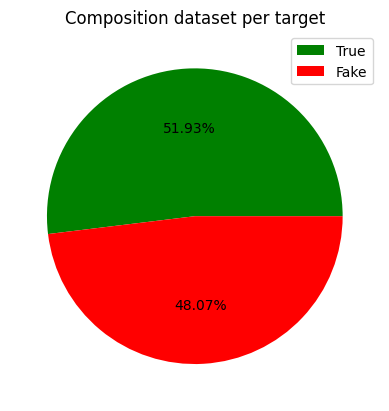

In [11]:
import matplotlib.pyplot as plt

color_map={0:"green",1:"red"}

plt.title("Composition dataset per target")
plt.pie(df["target"].value_counts(normalize=True)*100,autopct="%1.2f%%",colors=color_map.values())
plt.legend(labels=df["target"].rename(index={0:"True",1:"Fake"}).index)
plt.show()

Osserviamo una prevalenza di notizie vere, anche se il sbilanciamento a favore di questa classe è al minimo.

Il prossimo grafico mostra la suddivisione delle due classi in base al numero di parole del titolo e del testo.

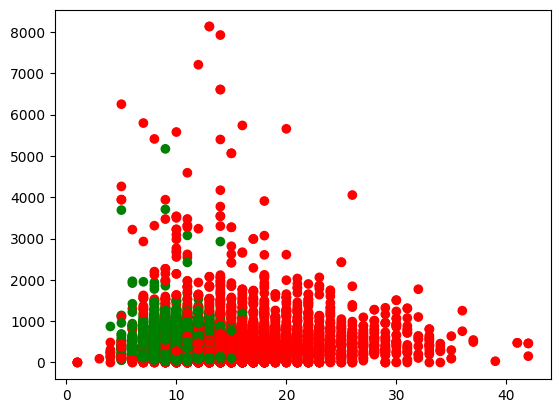

In [12]:
df["title_wordcount"]=df["title"].apply(lambda x: len(x.split()))
df["text_wordcount"]=df["text"].apply(lambda x: len(x.split()))

plt.scatter(df["title_wordcount"],df["text_wordcount"],c=df["target"].apply(lambda x: color_map[x]))
plt.show()

Si osserva quanto segue:
- In termini di numero di parole, le notizie vere sono limitate a un cluster dove il titolo è compreso tra le 5 e le 15 parole, mentre il corpo della notizia si mantiene in genere sotto le 2.000 parole;
- Sono presenti notizie false senza testo;
- Tranne alcune eccezioni, in genere i testi delle fake news si mantengono sotto le 2.000 parole, mentre i titoli tendono a essere più lunghi (oltre le 10 parole).

Durante l'analisi storica del dataset sono emersi errori nella colonna *date*. Si è deciso di gestirli mantenendo i soli record in cui la data è espressa nella forma "MMMM DD, YYYY" e di correggere i valori rimasti in modo che riportino solo il mese e l'anno della notizia.

In [13]:
df[["month","day","year"]]=df["date"].str.split(" ",expand=True).iloc[:,:3]
df["day"]=df["day"].str.replace(",","")
df

,title,text,subject,date,data,clean_data,target,title_wordcount,text_wordcount,month,day,year
0,“They Will Kill Him Before They Let Him Become...,This letter was originally attributed to well-...,politics,"Mar 7, 2016",“They Will Kill Him Before They Let Him Become...,""" kill let president "" letter originally attri...",1,10,1306,Mar,7,2016
1,"China, Taiwan spar over Chinese diplomat's inv...",BEIJING/TAIPEI (Reuters) - A threat by a senio...,worldnews,"December 11, 2017","China, Taiwan spar over Chinese diplomat's inv...",china taiwan spar chinese diplomat invasion th...,0,8,501,December,11,2017
2,"Replacing, repealing Obamacare at same time 'i...",WASHINGTON (Reuters) - Repealing and replacing...,politicsNews,"January 8, 2017","Replacing, repealing Obamacare at same time 'i...",replace repeal obamacare time ideal trump aide...,0,10,72,January,8,2017
3,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,Obama is probably huddled somewhere in the Whi...,Government News,"Jul 17, 2015",IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,"iranians celebrate nuclear deal obama chant "" ...",1,11,118,Jul,17,2015
4,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,Government News,"Apr 9, 2015","OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...","obama racism czar "" reverend "" al sharpton cal...",1,11,829,Apr,9,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
22444,Chicago mayor unveils 'gimmick-free' budget fo...,CHICAGO (Reuters) - Chicago Mayor Rahm Emanuel...,politicsNews,"October 18, 2017",Chicago mayor unveils 'gimmick-free' budget fo...,chicago mayor unveil gimmickfree budget fy c...,0,8,412,October,18,2017
22445,KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,"Former British Army officer, outspoken, conser...",left-news,"Dec 6, 2017",KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,katie hopkins warn americans grave danger ahea...,1,19,424,Dec,6,2017
22446,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,"December 20, 2017",White House aide sees temporary funding fix fo...,white house aide see temporary funding fix chi...,0,11,66,December,20,2017
22447,Afghans who helped U.S. forces get more visas ...,"WASHINGTON (Reuters) - An extra 2,500 visas fo...",politicsNews,"May 1, 2017",Afghans who helped U.S. forces get more visas ...,afghans help force visa funding bill washingto...,0,11,347,May,1,2017


In [14]:
df["month"].unique()

array(['Mar', 'December', 'January', 'Jul', 'Apr', 'Sep', 'March', 'July',
       'October', 'November', 'Jun', 'April', 'May', 'June', 'Dec',
       'September', 'February', 'August', 'Nov', 'Oct', 'Aug', 'Feb',
       'Jan', '15-Feb-18', '17-Feb-18',
       'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/',
       '18-Feb-18',
       'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg',
       '16-Feb-18', '19-Feb-18', '14-Feb-18',
       'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'],
      dtype=object)

In [15]:
df["day"].unique()

array(['7', '11', '8', '17', '9', '3', '13', '16', '5', '12', '21', '27',
       '19', '25', '23', '18', '14', '29', '26', '6', '30', '20', '4',
       '1', '10', '24', '31', '15', '22', '2', '28', None], dtype=object)

In [16]:
df["year"].unique()

array(['2016', '2017', '2015', None], dtype=object)

In [17]:
df["month"]=df["month"].replace({
    "Aug":"August",
    "Jul":"July",
    "Jun":"June",
    "Apr":"April",
    "Mar":"March",
    "Feb":"February",
    "Jan":"January",
    "Sep":"September",
    "Oct":"October",
    "Nov":"November",
    "Dec":"December"
})

df

,title,text,subject,date,data,clean_data,target,title_wordcount,text_wordcount,month,day,year
0,“They Will Kill Him Before They Let Him Become...,This letter was originally attributed to well-...,politics,"Mar 7, 2016",“They Will Kill Him Before They Let Him Become...,""" kill let president "" letter originally attri...",1,10,1306,March,7,2016
1,"China, Taiwan spar over Chinese diplomat's inv...",BEIJING/TAIPEI (Reuters) - A threat by a senio...,worldnews,"December 11, 2017","China, Taiwan spar over Chinese diplomat's inv...",china taiwan spar chinese diplomat invasion th...,0,8,501,December,11,2017
2,"Replacing, repealing Obamacare at same time 'i...",WASHINGTON (Reuters) - Repealing and replacing...,politicsNews,"January 8, 2017","Replacing, repealing Obamacare at same time 'i...",replace repeal obamacare time ideal trump aide...,0,10,72,January,8,2017
3,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,Obama is probably huddled somewhere in the Whi...,Government News,"Jul 17, 2015",IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,"iranians celebrate nuclear deal obama chant "" ...",1,11,118,July,17,2015
4,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,Government News,"Apr 9, 2015","OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...","obama racism czar "" reverend "" al sharpton cal...",1,11,829,April,9,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
22444,Chicago mayor unveils 'gimmick-free' budget fo...,CHICAGO (Reuters) - Chicago Mayor Rahm Emanuel...,politicsNews,"October 18, 2017",Chicago mayor unveils 'gimmick-free' budget fo...,chicago mayor unveil gimmickfree budget fy c...,0,8,412,October,18,2017
22445,KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,"Former British Army officer, outspoken, conser...",left-news,"Dec 6, 2017",KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,katie hopkins warn americans grave danger ahea...,1,19,424,December,6,2017
22446,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,"December 20, 2017",White House aide sees temporary funding fix fo...,white house aide see temporary funding fix chi...,0,11,66,December,20,2017
22447,Afghans who helped U.S. forces get more visas ...,"WASHINGTON (Reuters) - An extra 2,500 visas fo...",politicsNews,"May 1, 2017",Afghans who helped U.S. forces get more visas ...,afghans help force visa funding bill washingto...,0,11,347,May,1,2017


In [18]:
mask_month=df['month'].isin({'January',
                             'February',
                             'March',
                             'April',
                             'May',
                             'June',
                             'July',
                             'August',
                             'September',
                             'October',
                             'November',
                             'December'}).fillna(False)
mask_year=df['year'].isin({'2015', '2016', '2017', '2018'}).fillna(False)
mask_day=df['day'].str.isdigit().fillna(False)

In [19]:
original_count=df.shape[0]
df=df[mask_month & mask_year & mask_day]
original_count-df.shape[0]

23

In [20]:
df["date"]=df["month"]+"-"+df["year"]
df=df.drop(["day","month","year"],axis=1)
df["date"]=pd.to_datetime(df["date"])
df

/var/folders/vq/d4b211h10kjd14xrwcby13th0000gn/T/ipykernel_849/3600756333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"]=df["month"]+"-"+df["year"]
/var/folders/vq/d4b211h10kjd14xrwcby13th0000gn/T/ipykernel_849/3600756333.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"]=pd.to_datetime(df["date"])


,title,text,subject,date,data,clean_data,target,title_wordcount,text_wordcount
0,“They Will Kill Him Before They Let Him Become...,This letter was originally attributed to well-...,politics,2016-03-01,“They Will Kill Him Before They Let Him Become...,""" kill let president "" letter originally attri...",1,10,1306
1,"China, Taiwan spar over Chinese diplomat's inv...",BEIJING/TAIPEI (Reuters) - A threat by a senio...,worldnews,2017-12-01,"China, Taiwan spar over Chinese diplomat's inv...",china taiwan spar chinese diplomat invasion th...,0,8,501
2,"Replacing, repealing Obamacare at same time 'i...",WASHINGTON (Reuters) - Repealing and replacing...,politicsNews,2017-01-01,"Replacing, repealing Obamacare at same time 'i...",replace repeal obamacare time ideal trump aide...,0,10,72
3,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,Obama is probably huddled somewhere in the Whi...,Government News,2015-07-01,IRANIANS CELEBRATE NUCLEAR DEAL WITH OBAMA BY ...,"iranians celebrate nuclear deal obama chant "" ...",1,11,118
4,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...",Yeah putting the federal government in charge ...,Government News,2015-04-01,"OBAMA’S RACISM CZAR, “REVEREND” AL SHARPTON CA...","obama racism czar "" reverend "" al sharpton cal...",1,11,829
...,...,...,...,...,...,...,...,...,...
22444,Chicago mayor unveils 'gimmick-free' budget fo...,CHICAGO (Reuters) - Chicago Mayor Rahm Emanuel...,politicsNews,2017-10-01,Chicago mayor unveils 'gimmick-free' budget fo...,chicago mayor unveil gimmickfree budget fy c...,0,8,412
22445,KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,"Former British Army officer, outspoken, conser...",left-news,2017-12-01,KATIE HOPKINS WARNS AMERICANS Of Grave Danger ...,katie hopkins warn americans grave danger ahea...,1,19,424
22446,White House aide sees temporary funding fix fo...,WASHINGTON (Reuters) - A short-term fix to fun...,politicsNews,2017-12-01,White House aide sees temporary funding fix fo...,white house aide see temporary funding fix chi...,0,11,66
22447,Afghans who helped U.S. forces get more visas ...,"WASHINGTON (Reuters) - An extra 2,500 visas fo...",politicsNews,2017-05-01,Afghans who helped U.S. forces get more visas ...,afghans help force visa funding bill washingto...,0,11,347


Di seguito si mostra un grafico a linee del dataset così ottenuto.

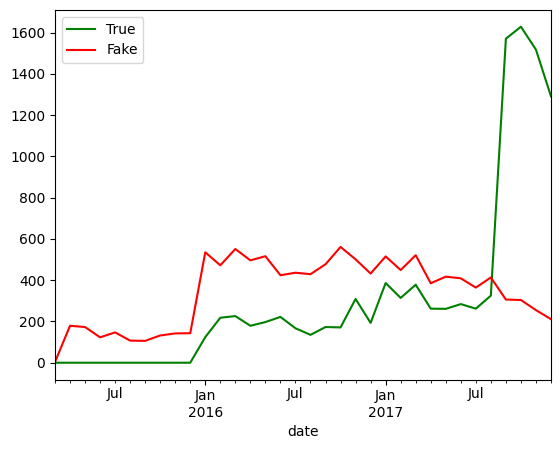

In [21]:
pd.crosstab(df["date"],df["target"]).plot(kind="line",color=color_map.values(),label=color_map.keys())
plt.legend(labels=df["target"].rename(index={0:"True",1:"Fake"}).index)
plt.show()

Si osserva una prevalenza di notizie false fino a luglio 2017, dove poi questa tendenza si è invertita a favore delle notizie vere. Da notare che il divario maggiore tra le due linee è avvenuto durante le elezioni presidenziali USA del 2016.

Concludiamo l'analisi esplorativa con la funzione *plot_wordcloud* che traccia una nuvola di parole a partire da un corpus di documenti allo scopo di evidenziare le parole maggiormente utilizzate. Questa funzione è stata poi applicata sulle fake news del dataset.

In [22]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(corpus):
    text = " ".join(corpus)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=STOPWORDS,
        min_font_size=10,
    ).generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

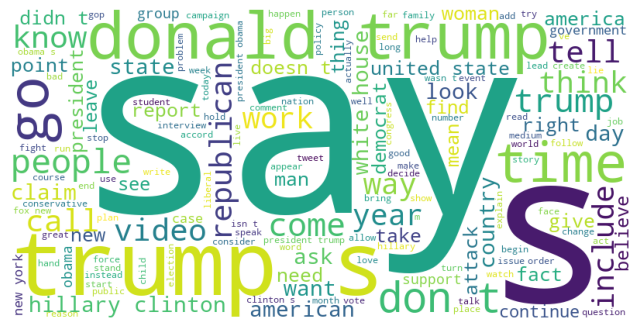

In [23]:
fake_list=df[df["target"]==1]["clean_data"].to_list()
plot_wordcloud(fake_list)

Osserviamo come la parola più utilizzata sia relativa al verbo dire (say) e che le più evidenti siano collegate alla politica americana del 2016 (Trump, Clinton, White House). Si suggerisce quindi di rendere il plug-in attivo durante gli eventi elettorali e politici.

## Preprocessing dei dati e addestramento del modello

In questa sezione si vedranno la vettorizzazione dei dati testuali e l'addestramento del modello di classificazione sul set di training.

Innanzitutto è stata definita la funzione *vectorize_corpus* che, dati un corpus di dati, un modello di vettorizzazione TF-IDF e un limite, restituisce il corpus vettorizzato e il modello dato in input.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_corpus(corpus, vectorizer, limit):
    if vectorizer==None:
        vectorizer=TfidfVectorizer(min_df=limit,max_df=1-limit)
        corpus_vectorized=vectorizer.fit_transform(corpus).toarray()
    else:
        corpus_vectorized=vectorizer.transform(corpus).toarray()

    return corpus_vectorized, vectorizer

È stato poi definito il dizionario *vectorizers* che raccoglie quanto segue:
- La lista *limit* contenente dieci float da usare per limitare il vocabolario del modello di vettorizzazione;
- La lista *vectorizer* con i modelli di vettorizzazione;
- La lista *corpus* con i testi vettorizzati.

In [25]:
vectorizers={
    "limit":[],
    "vectorizer":[],
    "corpus":[]
}

X=df["clean_data"].values

for limit in [i/100 for i in range(11)]:
  vectorizers["limit"].append(limit)

  corpus, vectorizer=vectorize_corpus(X,None,limit)

  vectorizers["vectorizer"].append(vectorizer)
  vectorizers["corpus"].append(corpus)

Trattandosi di un problema di classificazione del testo, è stato scelto un modello di Regressione Logistica, che assegna a ogni record la probabilità che sia una notizia vera o falsa.

I modelli ottenuti da ciascun modello di vettorizzazione sono stati salvati nella lista *model*.

In [26]:
from sklearn.linear_model import LogisticRegression

y_train=df["target"].values

vectorizers["model"]=[]

for corpus in vectorizers["corpus"]:
  model=LogisticRegression(random_state=0)
  model.fit(corpus,y_train)
  vectorizers["model"].append(model)

## Valutazione e ottimizzazione del modello

Questa sezione si divide in due parti:
- Nella prima sottosezione, utilizzando i dati nel file *test_1.csv*, si sceglierà il modello di classificazione e di vettorizzazione con l'accuratezza più elevata;
- Nella seconda sottosezione, utilizzandi i dati in *test_2.csv*, si ottimizzerà la soglia di probabilità per il modello selezionato.

### La migliore accuratezza

Carichiamo da *test_1.csv* i dati per il test dei modelli ed estraiamo le colonne *clean_data* e *target*.

In [27]:
df1=pd.read_csv("test_1.csv")
df1

,title,text,subject,date,data,clean_data,target
0,South Sudan needs $1.7 billion humanitarian ai...,JUBA (Reuters) - South Sudan needs $1.7 billio...,worldnews,"December 13, 2017",South Sudan needs $1.7 billion humanitarian ai...,south sudan need billion humanitarian aid ...,0
1,Japan to spend around $17 billion to subsidize...,TOKYO (Reuters) - Japan s government will set ...,worldnews,"November 25, 2017",Japan to spend around $17 billion to subsidize...,japan spend billion subsidize education medi...,0
2,BEAUTIFUL! MSNBC’s Chris Matthews ADMITS Trump...,How sweet is this? Chris Matthews had to admit...,politics,"Jun 8, 2017",BEAUTIFUL! MSNBC’s Chris Matthews ADMITS Trump...,beautiful msnbc chris matthews admit trump col...,1
3,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,left-news,"Apr 25, 2017",AZ RANCHERS Living On US-Mexico Border Destroy...,az rancher live usmexico border destroy nancy ...,1
4,Buffett hits back at Trump over tax comments,(Reuters) - Billionaire investor Warren Buffet...,politicsNews,"October 10, 2016",Buffett hits back at Trump over tax comments (...,buffett hit trump tax comment reuters billio...,0
...,...,...,...,...,...,...,...
13464,Syria's Assad meets once dissident footballers...,BEIRUT (Reuters) - Syrian President Bashar al-...,worldnews,"October 23, 2017",Syria's Assad meets once dissident footballers...,syria assad meet dissident footballer damascus...,0
13465,You Won’t Believe This Racist Alabama Math Te...,From the Civil War to Jim Crow to George Walla...,News,"June 1, 2016",You Won’t Believe This Racist Alabama Math Te...,will believe racist alabama math test video ...,1
13466,White House not aware of other nations plannin...,WASHINGTON (Reuters) - The White House said on...,worldnews,"December 7, 2017",White House not aware of other nations plannin...,white house aware nation plan recognize jerusa...,0
13467,WASTED? CNN ANCHOR’S Mic Cut After He Starts S...,Don Lemon wasted? Doing shots on the air and g...,politics,"Jan 1, 2017",WASTED? CNN ANCHOR’S Mic Cut After He Starts S...,waste cnn anchor mic cut start say ' awful’ ...,1


In [28]:
X_test_1=df1["clean_data"].values
y_test_1=df1["target"].values

Nella lista *predictions* del dizionario *vectorizers* salviamo le predizioni dei modelli addestrati in precedenza.

In [29]:
vectorizers["predictions"]=[]

for i in range(len(vectorizers["limit"])):
  corpus, _=vectorize_corpus(X_test_1,vectorizers["vectorizer"][i],0.0)
  vectorizers["predictions"].append(vectorizers["model"][i].predict(corpus))

Nella lista *accuracy* salviamo invece l'accuracy score di ciascun modello e cerchiamo il valore più alto.

In [31]:
from sklearn.metrics import accuracy_score

vectorizers["accuracy"]=[]
best_accuracy=0.0
best_model=-1

for y_pred_1 in vectorizers["predictions"]:
    accuracy=accuracy_score(y_test_1,y_pred_1)
    vectorizers["accuracy"].append(accuracy)

    if accuracy>=best_accuracy:
        best_accuracy=accuracy
        best_model=vectorizers["predictions"].index(y_pred_1)

Nel grafico sottostante, mostriamo gli accuracy score in funzione dei limiti imposti sul vocabolario ed evidenziamo in rosso il modello migliore.

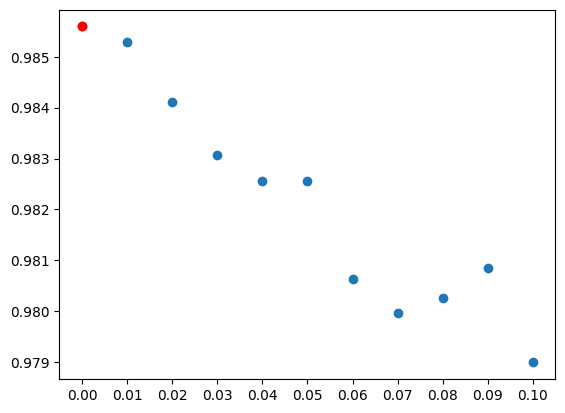

In [36]:
plt.scatter(vectorizers["limit"],vectorizers["accuracy"],marker="o")
plt.scatter(vectorizers["limit"][best_model],vectorizers["accuracy"][best_model],c="red")
plt.xticks(vectorizers["limit"])
plt.show()

Notiamo che il risultato migliore in termini di accuratezza è dato dal primo modello, che non pone limiti in termini di vocabolario. I modelli di vettorizzazione e classificazione corrispondenti vengono salvati in *vector_model* e *classifier_model* rispettivamente per essere ulteriormente migliorati nella prossima sottosezione.

In [38]:
vector_model=vectorizers["vectorizer"][best_model]
classifier_model=vectorizers["model"][best_model]

### Ottimizzazione della soglia di probabilità

Come visto in precedenza, carichiamo i dati da *test_2.csv* ed estraiamo le colonne *clean_data* e *target*.

In [39]:
df2=pd.read_csv("test_2.csv")
df2

,title,text,subject,date,data,clean_data,target
0,“GET USED TO IT”: Obama’s DHS Secretary Says I...,Jeh Johnson is supposed to enforce border secu...,politics,"Mar 25, 2016",“GET USED TO IT”: Obama’s DHS Secretary Says I...,""" "" obama dhs secretary say illegal "" effect ""...",1
1,Iraqi Kurds face more sanctions after calling ...,"ERBIL, Iraq (Reuters) - Iraq s autonomous Kurd...",worldnews,"October 3, 2017",Iraqi Kurds face more sanctions after calling ...,iraqi kurd face sanction call election erbil i...,0
2,Congress votes to call on Trump to denounce ha...,(Reuters) - The U.S. Congress passed a resolut...,politicsNews,"September 13, 2017",Congress votes to call on Trump to denounce ha...,congress vote trump denounce hate group reuter...,0
3,Trump signs order aimed at upgrading governmen...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"May 11, 2017",Trump signs order aimed at upgrading governmen...,trump sign order aim upgrade government cyber ...,0
4,HOW THE CLINTON’S GOT RICH Off Donations From ...,In January 2015 a group of Haitians surrounded...,left-news,"Aug 31, 2016",HOW THE CLINTON’S GOT RICH Off Donations From ...,clinton get rich donation people think help po...,1
...,...,...,...,...,...,...,...
8975,TRUMP WARNED AMERICANS We’d Be “Sick Of Winnin...,Trump warned us we d be sick of winning Who kn...,left-news,"Nov 14, 2016",TRUMP WARNED AMERICANS We’d Be “Sick Of Winnin...,"trump warn americans "" sick winning” … cnn cry...",1
8976,"BUSTED! DEM TX REP PLAYS RACE CARD, LIES ABOUT...",The race card thing is getting old fast The Au...,left-news,"Aug 9, 2015","BUSTED! DEM TX REP PLAYS RACE CARD, LIES ABOUT...",bust dem tx rep play race card lie treatment c...,1
8977,Donald Trump’s Security Agents Just Brutally ...,What we ve witnessed over the past several mon...,News,"February 29, 2016",Donald Trump’s Security Agents Just Brutally ...,donald trump security agent brutally choke s...,1
8978,Police union: Open carry of guns should be sus...,CLEVELAND (Reuters) - The head of the Clevelan...,politicsNews,"July 17, 2016",Police union: Open carry of guns should be sus...,police union open carry gun suspend republican...,0


In [40]:
X_test_2=df2["clean_data"].values
y_test_2=df2["target"].values

Utilizziamo i modelli selezionati nella precedente sottosezione per vettorizzare i testi e predire la probabilità che la notizia sia falsa.

In [41]:
corpus, _=vectorize_corpus(X_test_2,vector_model,0.0)
y_probs=classifier_model.predict_proba(corpus)[:,1]

Dal momento che lo scopo del modello è individuare le fake news, adotteremo come metriche di valutazione la precision (percentuale di fake news correttamente predette tra le notizie classificate come tali) e la recall (percentuale di fake news correttamente predette tra le notizie effettivamente false).

Per scegliere la migliore soglia di probabilità, si effettueranno le predizioni per ogni candidato e si calcoleranno i valori di precision e recall. I risultati sono mostrati nel grafico a linee sottostante.

In [42]:
from sklearn.metrics import precision_score, recall_score

thresholds=[i/1000 for i in range(1001)]
precision=[]
recall=[]

for threshold in thresholds:
    y_pred=[]
    for p in y_probs:
        if p>=threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

    precision.append(precision_score(y_test_2,y_pred))
    recall.append(recall_score(y_test_2,y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


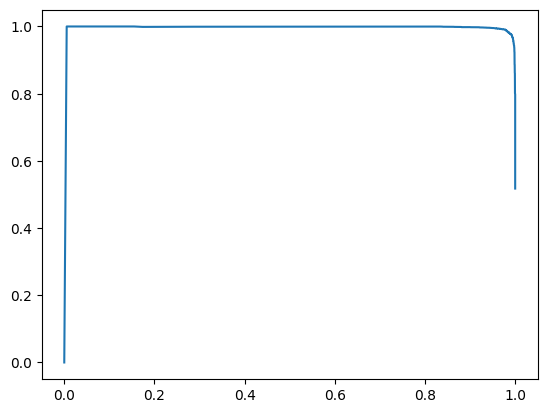

In [43]:
plt.plot(recall,precision)
plt.show()

Il modello che stiamo cercando è quello che offre i valori di precision e recall più vicini a quelli ideali, ossia 1 (i valori predetti sono tutti corretti) e 1 (tutte le fake news sono state individuate dal modello). In modo simile a quanto fatto per l'accuracy, si è quindi individuata la soglia di probabilità ottima per il modello e sono state effettuate le predizioni corrispondenti.

In [44]:
nearest_threshold=-0.01
min_distance=1.05
for i in range(len(thresholds)):
    distance=(((precision[i]-1.0)**2)+((recall[i]-1.0)**2))**0.5
    if distance<min_distance:
        min_distance=distance
        nearest_threshold=thresholds[i]

nearest_threshold

0.484

In [45]:
y_pred_std=classificator_model.predict(corpus)
y_pred_new=[]

for p in y_probs:
    if p>=nearest_threshold:
        y_pred_new.append(1)
    else:
        y_pred_new.append(0)

Di seguito si è costruito un DataFrame per confrontare la soglia standard (0.5) con quella individuata in questa sottosezione.

In [46]:
pd.DataFrame(
    {
        "thresholds":[0.5,nearest_threshold],
        "accuracy":[accuracy_score(y_test_2,y_pred_std),accuracy_score(y_test_2,y_pred_new)],
        "precision":[precision_score(y_test_2,y_pred_std),precision_score(y_test_2,y_pred_new)],
        "recall":[recall_score(y_test_2,y_pred_std),recall_score(y_test_2,y_pred_new)]
    }
)

,thresholds,accuracy,precision,recall
0,0.500,0.98363,0.987438,0.980852
1,0.484,0.98363,0.985126,0.983219


A parità di accuracy, la nuova soglia perde lievemente in termini di precision e ha un vantaggio in termini di recall.

## Esportazione dei modelli

In questa sezione vedremo l'esportazione dei modelli utilizzati in questo notebook.

I modelli sono stati esportati nei seguenti quattro file Pickle:
- Il file *cleaner.pickle* contiene la funzione per la pulizia del testo;
- Il file *vectorizer.pickle* contiene il modello di vettorizzazione che garantisce la migliore accuratezza;
- Il file *classifier.pickle* contiene il modello di Regressione Logistica;
- Il file *predictor.pickle* contiene la funzione *predict_from_prob* che classifica i testi in base alle probabilità da loro ottenute con il modello.

In [47]:
import pickle

with open("cleaner.pickle","wb") as f:
    pickle.dump(clean_sentence, f)

with open("vectorizer.pickle","wb") as f:
    pickle.dump(vector_model, f)

with open("classifier.pickle","wb") as f:
    pickle.dump(classificator_model,f)

def predict_from_prob(y_prob, threshold=nearest_threshold):
    y_pred=[]
    for p in y_probs:
        if p>=threshold:
            y_pred_new.append(1)
        else:
            y_pred_new.append(0)

    return y_pred

with open("predictor.pickle","wb") as f:
    pickle.dump(predict_from_prob,f)

## Conclusione

In questo notebook è stato vista la realizzazione di un filtro per fake news dall'importazione dei dati all'esportazione dei modelli.

Nella prima sezione abbiamo importato i dati forniti e abbiamo effettuato le prime trasformazioni. Al termine di questa sezione sono stati ottenuti tre file CSV per l'addestramento, il test del modello e la sua ottimizzazione.

Nella seconda sezione è stata svolta un'analisi esplorativa dei dati di addestramento in cui sono emerse relazioni tra il numero di parole e la falsità o meno del modello, oltre che una prevalenza di notizie false riguardanti la politica americana.

Nella terza sezione sono stati addestrati dei modelli di vettorizzazione del testo e di classificazione ponendo diversi limiti sulla grandezza del vocabolario. Questi modelli sono stati salvati in un dizionario per essere in seguito valutati in modo da selezionare il modello migliore.

La quarta sezione è stata divisa in due parti. Nella prima parte sono stati valutati i modelli ottenuti dalla terza sezione per selezionare quello con la migliore accuracy, mentre nella seconda parte è stata ottimizzata la soglia di probabilità oltre la quale una notizia è falsa o meno.

Nell'ultima sezione sono stati esportati quattro modelli in formato Pickle che processano i dati testuali dalla loro pulizia fino alla classificazione finale.